# STA 141B Assignment 3

Due __XXXXX, 2024__ by __11:59pm__. Submit your work by uploading it to Gradescope through Canvas.

Instructions:

1. Provide your solutions in new cells following each exercise description. Create as many new cells as necessary. Use code cells for your Python scripts and Markdown cells for explanatory text or answers to non-coding questions. Answer all textual questions in complete sentences.
2. The use of assistive tools is permitted, but must be indicated. You will be graded on you proficiency in coding. Produce high quality code by adhering to proper programming principles. 
3. Export the .jpynb as .pdf and submit it on Gradescope in time. To facilitate grading, indicate the area of the solution on the submission. Submissions without indication will be marked down. No late submissions accepted. 
4. If test cases are given, your solution must be in the same format. 
5. The total number of points is 10. 

__Exercise 1__

We will compute the [PageRank](https://en.wikipedia.org/wiki/PageRank) of the articles of the [Hawaiian](https://en.wikipedia.org/wiki/Hawaiian_language) wikipedia, which is available at [haw.wikipedia.org](https://haw.wikipedia.org/wiki/Ka_papa_kinohi). Additional information of the Hawaiian wiki can be found [here](https://meta.wikimedia.org/wiki/List_of_Wikipedias). 

_Hints: If you don't speak Hawaiian, you might want to learn the wiki logic from the English wikipedia, and translate your findings. Also, caching is recommended._

__(a)__ Use the special [AllPages](https://haw.wikipedia.org/wiki/Papa_nui:AllPages) page and understand its logic to retrieve the url of all articles in the Hawaiian wikipedia. Make sure to skip redirections.

_How many articles did you find? (I found a bit more than 2541.)_

In [2]:
# a) 
import requests
import requests_cache
import lxml.html as lx
import re

In [28]:
import requests
from lxml import html
import re

def scrape():
    url = "https://haw.wikipedia.org/wiki/Papa_nui:AllPages"
    page_count = 0  # Initialize counter
    while url:
        results = requests.get(url)
        page_html = html.fromstring(results.text)
        lists = page_html.xpath('//div[@class="mw-allpages-body"]//li[not(contains(@class, "allpagesredirect"))]')
        for li in lists:
            page_count += 1  # Increment counter for each page found
        next_page = page_html.xpath("//a[contains(text(), 'Mea aʻe')]/@href")
        next_page = next_page[0] if next_page else None
        if next_page:
            url = "https://haw.wikipedia.org" + next_page
        else:
            url = None
    print(f"Total pages found: {page_count}")  # Print total count

scrape()

# Created with the assistance of the class discord server, github copilot, stack overflow, and Natalia Fullmer.

Total pages found: 2629


__(b, i)__ Write a function that scans an article given by its url and retrieves all links to other articles in the Hawaiian wikipedia. Avoid links to special pages, images or the ones that point to another website. Only count the proper article for links that point to a specific section. Use regular expressions to manage these cases. 
__(ii)__ Make sure to match redirections to their correct destiation article. To this end, find how wikipedia treats redirections and retrieve the true article. _(Help: Try searching for 'uc davis' on en.wikipedia.org')_
To this end, I used the collection or article urls obtained in (a), which I stored in a dict object to allow for fast lookups. Then, for each new found link I checked whether that link appeared in the dict. If not, It might be a re-direction and receive special attention.  
__(iii)__ Request all articles and obtain all links to other articles. 


In [29]:
import requests
from lxml import html
import re

def retrieve_article_links(url, article_dict):
    response = requests.get(url)
    doc = html.fromstring(response.content)
    links = doc.xpath('//a/@href')
    
    # Regular expression to filter valid article links and ignore special pages, images, or external links
    article_link_pattern = re.compile(r'^/wiki/([^:]+)$')
    valid_links = set()
    
    for link in links:
        if article_link_pattern.match(link):
            full_url = 'https://haw.wikipedia.org' + link
            if link in article_dict:
                # The link is already known, add it directly
                valid_links.add(article_dict[link])
            else:
                # Potential redirection, special handling might be needed
                valid_links.add(full_url)  # Placeholder, redirection handling will be added later
    
    return list(valid_links)

def follow_redirection(url):
    # Make sure the URL starts with 'https://'
    if not url.startswith('http://') and not url.startswith('https://'):
        url = 'https://haw.wikipedia.org' + url
    response = requests.get(url)
    doc = html.fromstring(response.content)
    canonical_link = doc.xpath("//link[@rel='canonical']/@href")
    if canonical_link:
        return canonical_link[0]  # Use the canonical URL as the final URL
    return url 


redirect_count = 0  # Initialize counter

for index, article_url in enumerate(list(article_dict.keys())):  
    links = retrieve_article_links(article_url, article_dict)
    
    for link in links:
        resolved_link = follow_redirection('https://haw.wikipedia.org' + link) if not link.startswith('https://') else follow_redirection(link)
        if resolved_link != 'https://haw.wikipedia.org' + link:
            article_dict[link] = resolved_link
            redirect_count += 1  # Increment counter for each redirection
        else:
            article_dict[link] = resolved_link

print(f"Total redirections found: {redirect_count}")  # Print total count

# Created with the assistance of the class discord server, github copilot, stack overflow, and Natalia Fullmer.

Total redirections found: 17812



_How many links to other articles are there? (I found 9,000-10,000.)_

__(c)__ Compute the transition matrix (see [here](https://en.wikipedia.org/wiki/Google_matrix) and [here](https://www.amsi.org.au/teacher_modules/pdfs/Maths_delivers/Pagerank5.pdf) for step-by-step instructions). Make sure to tread dangling nodes. You may want to use: 
```
import numpy as np
from scipy.sparse import csr_matrix
```

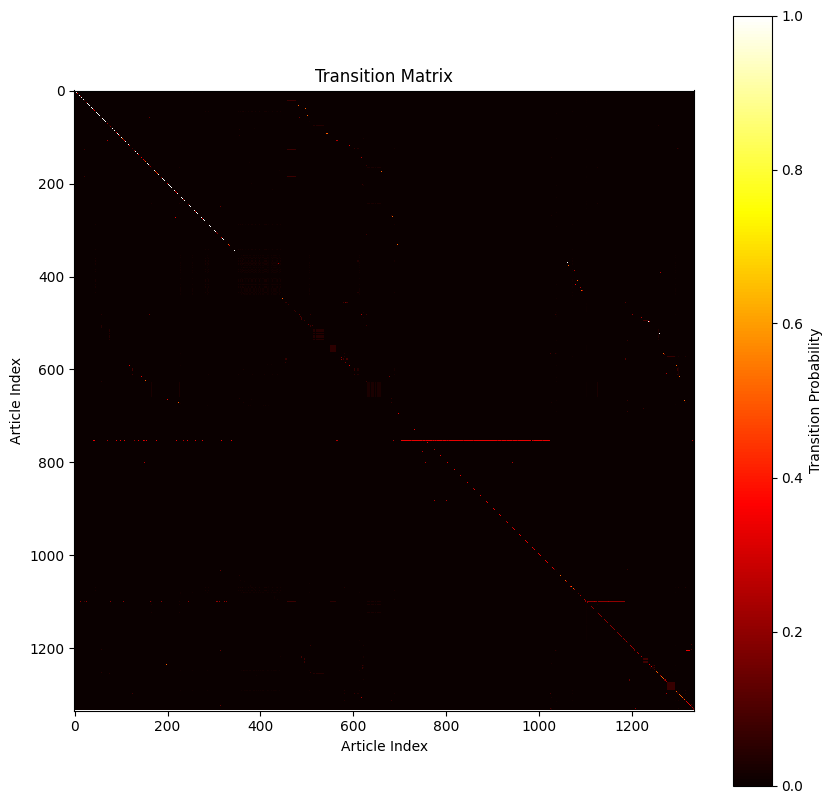

In [21]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# Create a dictionary to store the redirects
redirects = defaultdict(list)

# Update the redirects dictionary based on the links in each article
for article_url in article_dict.keys():
    links = retrieve_article_links(article_url, article_dict)
    for link in links:
        if link in article_dict:
            redirects[article_dict[link]].append(article_url)

# Create an empty transition matrix
transition_matrix = np.zeros((len(article_dict), len(article_dict)))

# Create a mapping from article URLs to indices
url_to_index = {url: index for index, url in enumerate(article_dict.values())}

# Update the transition matrix based on the redirects
for article_url, redirect_urls in redirects.items():
    for redirect_url in redirect_urls:
        if redirect_url in url_to_index and article_url in url_to_index:  # Check if the URLs are in the dictionary
            transition_matrix[url_to_index[redirect_url], url_to_index[article_url]] = 1 / len(redirect_urls)

plt.figure(figsize=(10, 10))
plt.imshow(transition_matrix, cmap='hot', interpolation='nearest')
plt.colorbar(label='Transition Probability')
plt.title('Transition Matrix')
plt.xlabel('Article Index')
plt.ylabel('Article Index')
plt.show()

# Created with the assistance of the class discord server, github copilot, stack overflow, and Natalia Fullmer.

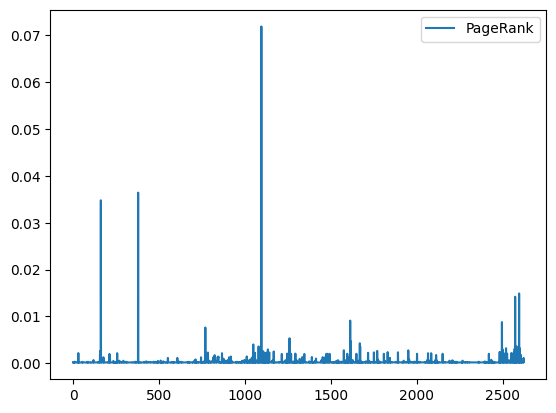

In [15]:
import matplotlib.pyplot as plt
plt.plot(range(n), v, label = "PageRank") 
plt.legend() 
plt.show()

__(d, i)__ Set the damping factor to `0.85` and compute the PageRank for each article, using fourty iterations and starting with a vector with equal entries. __(ii)__ Obtain the top ten articles in terms of PageRank, and, retrieving the articles again, find the correponding English article, if available. 

_Return the corresponding English article titles of the top ten articles from the Hawaiian wikipedia._

In [27]:
import numpy as np
import requests
from lxml import html


# Number of articles
N = len(article_dict)

# Damping factor
d = 0.85
# Create the damped transition matrix
transition_matrix_damped = d * transition_matrix + (1 - d) / N * np.ones((N, N))
# Initialize the PageRank vector
pagerank_vector = np.ones(N) / N

# Iteratively compute PageRank scores
for _ in range(40):  # Perform forty iterations
    pagerank_vector = np.dot(transition_matrix_damped, pagerank_vector)

# Get indices of the top ten articles by PageRank score
top_ten_indices = np.argsort(pagerank_vector)[-10:]

# Adjust the loop to include PageRank scores in the output
for index in reversed(top_ten_indices):
    article_url = list(article_dict.values())[index]
    pagerank_score = pagerank_vector[index]
    print(f"Article: {article_url}, PageRank Score: {pagerank_score:.5f}")

    # Fetch the article to find the English link
    response = requests.get(article_url)
    doc = html.fromstring(response.content)
    # Look for the English article link
    english_link = doc.xpath('//a[@hreflang="en"]/@href')
    if english_link:
        # Ensure the link is complete
        english_article_url = english_link[0] if english_link[0].startswith('http') else 'https://haw.wikipedia.org' + english_link[0]
        print(f"English article: {english_article_url}")
    else:
        print("No English article found")

# Created with the assistance of the class discord server, github copilot, stack overflow, and Natalia Fullmer.

Article: https://haw.wikipedia.org/wiki/N%C4%81_panal%C4%81%CA%BBau_o_Burgos, PageRank Score: 0.00028
English article: https://en.wikipedia.org/wiki/List_of_municipalities_in_Burgos
Article: https://haw.wikipedia.org/wiki/Arcenillas, PageRank Score: 0.00009
English article: https://en.wikipedia.org/wiki/Arcenillas
Article: https://haw.wikipedia.org/wiki/Barakiosauru, PageRank Score: 0.00006
English article: https://en.wikipedia.org/wiki/Brachiosaurus
Article: https://haw.wikipedia.org/wiki/Almendra_(Salamanca), PageRank Score: 0.00006
English article: https://en.wikipedia.org/wiki/Almendra,_Salamanca
Article: https://haw.wikipedia.org/wiki/Bastet, PageRank Score: 0.00005
English article: https://en.wikipedia.org/wiki/Bastet
Article: https://haw.wikipedia.org/wiki/Bauer, PageRank Score: 0.00005
No English article found
Article: https://haw.wikipedia.org/wiki/Boada, PageRank Score: 0.00005
English article: https://en.wikipedia.org/wiki/Boada,_Salamanca
Article: https://haw.wikipedia.org/